## IBM Data Science Professional Certificate
#### This Jupypter Notebook will be used for the Applied Data Science Capstone

In [2]:
# Import the needed libraries

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from bs4 import BeautifulSoup

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.0               |             py_0          26 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

In [4]:
# Specify the URL needing to be scraped for Canadian postal codes in the Toronto area
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

# Use BeautifulSoup to retrieve and prettify the Canadian postal code content
soup = BeautifulSoup(website_url, 'lxml')
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of postal codes of Canada: M - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgMonthNamesShort":["","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],"wgRequestId":"XldtXgpAICwAAA@bU3AAAABP","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":942851379,"wgRevisionId":942851379,"wgArticleId":539066,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Communi

In [5]:
# Locate the table containing the postal code information on the Wikipedia page

My_table = soup.find('table',{'class':'wikitable sortable'})

In [6]:
# Build the dataframe that will hold the Canadian postal code information for the Toronto area

A=[] #PostalCode
B=[] #Borough
C=[] #Neighborhood

for row in My_table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==3:
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))
        
df=pd.DataFrame(A, columns=['PostalCode'])
df['Borough'] = B
df['Neighborhood'] = C


# Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned
df.drop(df[df['Borough'] == 'Not assigned'].index, inplace=True)


# Sort data frame by postal code, then by borough, then by neighborhood
df.sort_values(by=['PostalCode','Borough','Neighborhood'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Preview the data frame
df.head(20)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,Malvern
1,M1B,Scarborough,Rouge
2,M1C,Scarborough,Highland Creek
3,M1C,Scarborough,Port Union
4,M1C,Scarborough,Rouge Hill
5,M1E,Scarborough,Guildwood
6,M1E,Scarborough,Morningside
7,M1E,Scarborough,West Hill
8,M1G,Scarborough,Woburn
9,M1H,Scarborough,Cedarbrae


In [7]:
# More than one neighborhood can exist in one postal code area. 
# For example, in the table on the Wikipedia page, you will notice that M5A 
# is listed twice and has two neighborhoods: Harbourfront and Regent Park. 
# These two rows will be combined into one row with the neighborhoods 
# separated with a comma as shown in project instructions.

df = df.groupby(['PostalCode','Borough'])['Neighborhood'].apply(', '.join).reset_index()

In [8]:
# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

df['Neighborhood'] = np.where(df['Neighborhood'] == 'Not assigned', df['Borough'], df['Neighborhood'])

In [9]:
# Data cleanup to remove new line characters in messy strings

df = df.replace('\n', '', regex=True)

In [10]:
# Preview the dataframe

df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [11]:
# Use the .shape method to print the number of rows of dataframe

df.shape

(103, 3)

In [12]:
# Retrieve the geographic coordinates of postal codes

pc = pd.read_csv('http://cocl.us/Geospatial_data')

In [13]:
# Perform merge in order to attach lat/long coordinates to data frame

df2 = df.merge(pc, left_on='PostalCode', right_on='Postal Code', how='left')
df2.drop('Postal Code', axis=1, inplace=True)
df2.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [14]:
# Instructions suggest limiting analysis to only boroughs having Toronto in their name

Toronto_Neigh = df2[df2['Borough'].str.contains("Toronto")]
Toronto_Neigh.reset_index(drop=True, inplace=True)
Toronto_Neigh

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"Riverdale, The Danforth West",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
7,M4S,Central Toronto,Davisville,43.704324,-79.388790
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
9,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049


#### Create a map of Toronto, Ontario with neighborhoods (unique postal codes) superimposed on top.

In [15]:
# Center map on Toronto
latitude = 43.662301
longitude = -79.389494

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label, postal in zip(Toronto_Neigh['Latitude'], Toronto_Neigh['Longitude'], Toronto_Neigh['Neighborhood'], Toronto_Neigh['PostalCode']):
    label = folium.Popup((postal + ' - ' + label), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Specify the Foursquare Credentials and Version

In [16]:
CLIENT_ID = 'RZN41NECPKFRJGW2RBLGT4OOS00TAHBJMLX2WPPRVXIRY2FF' # your Foursquare ID
CLIENT_SECRET = 'LGQ1PSSEXGCF4HDQYIBHIORBOGCC0ZUCFR4RORAPZ02ORMY0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RZN41NECPKFRJGW2RBLGT4OOS00TAHBJMLX2WPPRVXIRY2FF
CLIENT_SECRET:LGQ1PSSEXGCF4HDQYIBHIORBOGCC0ZUCFR4RORAPZ02ORMY0


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [17]:
Toronto_Neigh.loc[0, 'Neighborhood']

'The Beaches'

Get the neighborhood's latitude and longitude values.

In [18]:
neighborhood_latitude = Toronto_Neigh.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Toronto_Neigh.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = Toronto_Neigh.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of The Beaches are 43.67635739999999, -79.2930312.


#### Now, let's get the top 100 venues that are in The Beaches within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [19]:
# type your answer here

LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=RZN41NECPKFRJGW2RBLGT4OOS00TAHBJMLX2WPPRVXIRY2FF&client_secret=LGQ1PSSEXGCF4HDQYIBHIORBOGCC0ZUCFR4RORAPZ02ORMY0&v=20180605&ll=43.67635739999999,-79.2930312&radius=500&limit=100'

Send the GET request and examine the results

In [20]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e5eef60963d29001b582a92'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'The Beaches',
  'headerFullLocation': 'The Beaches, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 5,
  'suggestedBounds': {'ne': {'lat': 43.680857404499996,
    'lng': -79.28682091449052},
   'sw': {'lat': 43.67185739549999, 'lng': -79.29924148550948}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bd461bc77b29c74a07d9282',
       'name': 'Glen Manor Ravine',
       'location': {'address': 'Glen Manor',
        'crossStreet': 'Queen St.',
        'lat': 43.67682094413784,
        'lng': -79.29394208780985,
        'labeledLatLngs': [{'labe

In [21]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [22]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Glen Manor Ravine,Trail,43.676821,-79.293942
1,The Big Carrot Natural Food Market,Health Food Store,43.678879,-79.297734
2,Grover Pub and Grub,Pub,43.679181,-79.297215
3,Upper Beaches,Neighborhood,43.680563,-79.292869
4,Dip 'n Sip,Coffee Shop,43.678897,-79.297745


And how many venues were returned by Foursquare?

In [23]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

5 venues were returned by Foursquare.


## Explore Neighborhoods in Toronto

#### Let's create a function to repeat the same process to all the neighborhoods in Toronto

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *toronto_venues*.

In [25]:
toronto_venues = getNearbyVenues(names=Toronto_Neigh['Neighborhood'],
                                   latitudes=Toronto_Neigh['Latitude'],
                                   longitudes=Toronto_Neigh['Longitude']
                                  )



The Beaches
Riverdale, The Danforth West
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
North Midtown, The Annex, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
Bathurst Quay, CN Tower, Harbourfront West, Island airport, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The Junction Sout

#### Let's check the size of the resulting dataframe

In [29]:
print(toronto_venues.shape)
toronto_venues.head()

(1729, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,The Beaches,43.676357,-79.293031,Dip 'n Sip,43.678897,-79.297745,Coffee Shop


Let's check how many venues were returned for each neighborhood

In [30]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
"Bathurst Quay, CN Tower, Harbourfront West, Island airport, King and Spadina, Railway Lands, South Niagara",18,18,18,18,18,18
Berczy Park,57,57,57,57,57,57
"Brockton, Exhibition Place, Parkdale Village",24,24,24,24,24,24
Business Reply Mail Processing Centre 969 Eastern,16,16,16,16,16,16
"Cabbagetown, St. James Town",42,42,42,42,42,42
Central Bay Street,80,80,80,80,80,80
"Chinatown, Grange Park, Kensington Market",90,90,90,90,90,90
Christie,18,18,18,18,18,18


#### Let's find out how many unique categories can be curated from all the returned venues

In [31]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 236 uniques categories.


## Analyze Each Neighborhood

In [32]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

And let's examine the new dataframe size.

In [33]:
toronto_onehot.shape

(1729, 236)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [34]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.00,0.000000,0.000000,0.020000,0.000000,0.0000,0.000000,0.000000,0.000000,0.020000,0.000000,0.040000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.010000,0.000000,0.01,0.020000,0.000000,0.000000,0.01,0.020000,0.010000,0.000000,0.000000,0.000000,0.040000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.070000,0.000000,0.00000,0.000000,0.00,0.01,0.000000,0.0000,0.020000,0.000000,0.020000,0.00000,0.00

#### Let's confirm the new size

In [35]:
toronto_grouped.shape

(39, 236)

#### Let's print each neighborhood along with the top 5 most common venues

In [36]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
             venue  freq
0      Coffee Shop  0.07
1  Thai Restaurant  0.04
2              Bar  0.04
3       Restaurant  0.04
4             Café  0.04


----Bathurst Quay, CN Tower, Harbourfront West, Island airport, King and Spadina, Railway Lands, South Niagara----
                 venue  freq
0      Airport Service  0.17
1       Airport Lounge  0.11
2     Airport Terminal  0.11
3                Plane  0.06
4  Rental Car Location  0.06


----Berczy Park----
            venue  freq
0     Coffee Shop  0.07
1    Cocktail Bar  0.04
2        Beer Bar  0.04
3  Farmers Market  0.04
4      Restaurant  0.04


----Brockton, Exhibition Place, Parkdale Village----
                venue  freq
0                Café  0.12
1         Coffee Shop  0.08
2      Breakfast Spot  0.08
3         Yoga Studio  0.04
4  Italian Restaurant  0.04


----Business Reply Mail Processing Centre 969 Eastern----
           venue  freq
0    Yoga Studio  0.06
1  Auto Workshop  0.06
2     Co

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [79]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Restaurant,Bar,Café,Thai Restaurant,Steakhouse,Sushi Restaurant,Gym,Lounge,Cosmetics Shop
1,"Bathurst Quay, CN Tower, Harbourfront West, Is...",Airport Service,Airport Lounge,Airport Terminal,Sculpture Garden,Boutique,Bar,Rental Car Location,Plane,Boat or Ferry,Coffee Shop
2,Berczy Park,Coffee Shop,Beer Bar,French Restaurant,Restaurant,Café,Bakery,Seafood Restaurant,Cheese Shop,Cocktail Bar,Farmers Market
3,"Brockton, Exhibition Place, Parkdale Village",Café,Coffee Shop,Breakfast Spot,Performing Arts Venue,Stadium,Burrito Place,Restaurant,Climbing Gym,Pet Store,Music Venue
4,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Auto Workshop,Skate Park,Brewery,Spa,Farmers Market,Fast Food Restaurant,Burrito Place,Restaurant,Butcher


## Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [80]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

inertias = [] 
mapping1 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(toronto_grouped_clustering) 
    kmeanModel.fit(toronto_grouped_clustering)     
      
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = kmeanModel.inertia_ 

In [81]:
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 
    


1 : 3.55358620740005
2 : 2.5647500918059682
3 : 2.0869142253192514
4 : 1.7591448522780146
5 : 1.5160892967224588
6 : 1.4473920664741666
7 : 1.231791676324061
8 : 1.098341209387629
9 : 1.0320758561176615


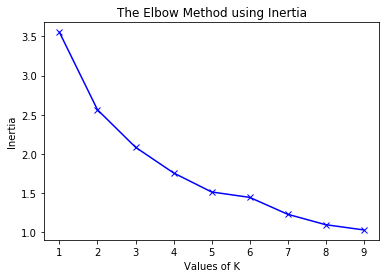

In [82]:
import matplotlib.pyplot as plt   
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [83]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [84]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = Toronto_Neigh

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Coffee Shop,Health Food Store,Pub,Trail,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
1,M4K,East Toronto,"Riverdale, The Danforth West",43.679557,-79.352188,1,Greek Restaurant,Italian Restaurant,Coffee Shop,Bookstore,Ice Cream Shop,Furniture / Home Store,Frozen Yogurt Shop,Pub,Pizza Place,Liquor Store
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,1,Park,Sushi Restaurant,Sandwich Place,Brewery,Liquor Store,Italian Restaurant,Burrito Place,Fast Food Restaurant,Ice Cream Shop,Steakhouse
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,Gastropub,American Restaurant,Brewery,Bakery,Italian Restaurant,Latin American Restaurant,Park,Seafood Restaurant
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,3,Park,Swim School,Bus Line,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


Finally, let's visualize the resulting clusters

In [90]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Resulting Clusters

#### Cluster 0: Downtown Toronto (M4W)
#### Cluster 1: 35 postal codes, majority of Greater Toronto
#### Cluster 2: Central Toronto: Roselawn (M5N)
#### Cluster 3: Central Toronto: Lawrence Park (M4N)
#### Cluster 4: Central Toronto: Moore Park, Summerhill East (M4T)



In [88]:
toronto_merged.sort_values(by=['Cluster Labels','PostalCode'])

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,0,Park,Playground,Trail,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Coffee Shop,Health Food Store,Pub,Trail,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
1,M4K,East Toronto,"Riverdale, The Danforth West",43.679557,-79.352188,1,Greek Restaurant,Italian Restaurant,Coffee Shop,Bookstore,Ice Cream Shop,Furniture / Home Store,Frozen Yogurt Shop,Pub,Pizza Place,Liquor Store
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,1,Park,Sushi Restaurant,Sandwich Place,Brewery,Liquor Store,Italian Restaurant,Burrito Place,Fast Food Restaurant,Ice Cream Shop,Steakhouse
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,Gastropub,American Restaurant,Brewery,Bakery,Italian Restaurant,Latin American Restaurant,Park,Seafood Restaurant
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197,1,Dog Run,Park,Gym,Breakfast Spot,Food & Drink Shop,Asian Restaurant,Sandwich Place,Department Store,Hotel,Diner
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,1,Clothing Store,Coffee Shop,Yoga Studio,Salon / Barbershop,Restaurant,Café,Chinese Restaurant,Pet Store,Mexican Restaurant,Sporting Goods Shop
7,M4S,Central Toronto,Davisville,43.704324,-79.388790,1,Pizza Place,Dessert Shop,Sandwich Place,Italian Restaurant,Café,Coffee Shop,Sushi Restaurant,Gym,Indoor Play Area,Discount Store
9,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049,1,Pub,Coffee Shop,Bagel Shop,Burger Joint,Sports Bar,Fried Chicken Joint,Pizza Place,Sushi Restaurant,American Restaurant,Restaurant
11,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675,1,Restaurant,Coffee Shop,Italian Restaurant,Pub,Bakery,Pizza Place,Café,Pet Store,Butcher,Japanese Restaurant
